##  using natural language processing

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('spam.csv',encoding="ISO-8859-1")

In [3]:
data = data[["v1","v2"]]
data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


    Task: To classify an email into spam or not spam
    To get our solution we are going to apply the four concepts below:
        1-Text processing
        2-text sequencing
        3-Model selection
        4-Implementation
    Text Processing Fundamentels:
        1-cleaning the raw data:
            .lowering case
            .Remove special characters
            .remove stopwords
            .remove hyperlinks
            .remove numbers
            .remove white spaces
        2-Tokinizing the cleaned data

In [4]:
#Lowering case
def ToLower(word):
    result = word.lower()
    return result

In [5]:
#remove_special characters (# $ @ ....)
def remove_special_characters(word):
    # result = re.sub('[^A-Za-z0-9]+', ' ', word)
    result = []
    tokenizer = RegexpTokenizer(r'\w+')
    i=0
    for s in word:
        result.append(' '.join(tokenizer.tokenize(s)))
    return result

In [6]:
#remove stop words
def remove_stop_words(word):
    tokens = []
    filtered = []
    for s in word: 
        tokens.append(word_tokenize(s))
    for s in tokens:
        words = []
        for k in s:
            if not ToLower(k) in stopwords.words('english'):
                words.append(k)
        filtered.append(' '.join(words))
    
    # filtered=[token for token in word if not ToLower(token) in stopwords.words('english')]
    return filtered

In [7]:
#test function
remove_stop_words(remove_special_characters(["hadi is okay and his sister @ is not # in the house, she is outside"]))

['hadi okay sister house outside']

In [8]:
def remove_hyperLinks_numbers(word):
    text =[]
    for s in word:
        #remove hyperLinks
        text1 = re.sub(r"https\S+", "" , s)
        #remove numbers
        text2 = re.sub(r'\d+', '', text1)
        #remove extra spaces
        text.append(re.sub(' + ', '', text2).lstrip().rstrip())
    return text

In [9]:
remove_hyperLinks_numbers(["https://www.google.com hadi monzzer 1212"," hahahaha"])

['hadi monzzer', 'hahahaha']

In [10]:
#cleaning the data
# result = remove_special_characters(data['v2']) 
result = remove_stop_words(data["v2"])
result = remove_special_characters(result)
result = remove_hyperLinks_numbers(result)
result[0]

'Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat'

In [11]:
#adding the cleaned messages to the data
data['cleaned-messages']=result
data

,v1,v2,cleaned-messages
0,ham,"Go until jurong point, crazy.. Available only ...",Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entrywkly comp win FA Cup final tkts st M...
3,ham,U dun say so early hor... U c already then say...,U dun say early hor U c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah n t think goes usf lives around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,nd time triedcontact u U åPound prizeclaim eas...
5568,ham,Will Ì_ b going to esplanade fr home?,Ì_ b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",Pity mood suggestions
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like d interested buying so...


In [12]:
data['length'] = data['cleaned-messages'].apply(len)
data.head()

,v1,v2,cleaned-messages,length
0,ham,"Go until jurong point, crazy.. Available only ...",Go jurong point crazy Available bugis n great ...,82
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,23
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entrywkly comp win FA Cup final tkts st M...,107
3,ham,U dun say so early hor... U c already then say...,U dun say early hor U c already say,35
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah n t think goes usf lives around though,42


[Text(0.5, 0, 'Message Length Class'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Length Distribution')]

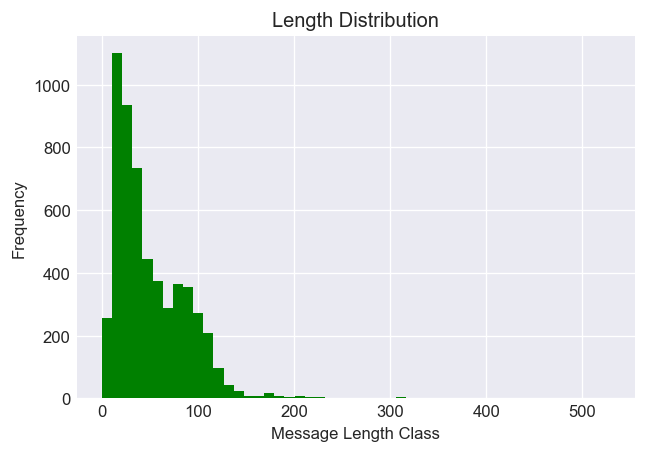

In [13]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(dpi = 120)
ax = plt.axes()
data['length'].plot(bins=50, kind='hist',ax=ax,color = 'green')
ax.set(xlabel = 'Message Length Class',ylabel = 'Frequency',title = 'Length Distribution')

In [14]:
freq = data.groupby('length',as_index=False).count()
freq[["cleaned-messages","length"]].T

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
cleaned-messages,8,3,21,14,25,8,31,29,28,39,...,1,1,3,2,2,1,1,1,1,1
length,0,1,2,3,4,5,6,7,8,9,...,274,275,308,326,341,392,398,405,432,528


In [15]:
data[data['length'] == 0]

,v1,v2,cleaned-messages,length
252,ham,What you doing?how are you?,,0
959,ham,Where @,,0
1611,ham,645,,0
2805,ham,Can a not?,,0
3374,ham,:),,0
4115,ham,What you doing?how are you?,,0
4573,ham,:( but your not here....,,0
4822,ham,:-) :-),,0


In [16]:
data = data.drop(data[data['length']==0].index)
data

,v1,v2,cleaned-messages,length
0,ham,"Go until jurong point, crazy.. Available only ...",Go jurong point crazy Available bugis n great ...,82
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,23
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entrywkly comp win FA Cup final tkts st M...,107
3,ham,U dun say so early hor... U c already then say...,U dun say early hor U c already say,35
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah n t think goes usf lives around though,42
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,nd time triedcontact u U åPound prizeclaim eas...,85
5568,ham,Will Ì_ b going to esplanade fr home?,Ì_ b going esplanade fr home,28
5569,ham,"Pity, * was in mood for that. So...any other s...",Pity mood suggestions,21
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like d interested buying so...,81


In [17]:
data["length"].describe()

count    5564.000000
mean       50.738497
std        38.737743
min         1.000000
25%        22.000000
50%        38.000000
75%        75.000000
max       528.000000
Name: length, dtype: float64

In [18]:
data[data['length'] == 528]

,v1,v2,cleaned-messages,length
1084,ham,For me the love should start with attraction.i...,love start attraction i feel need every time a...,528


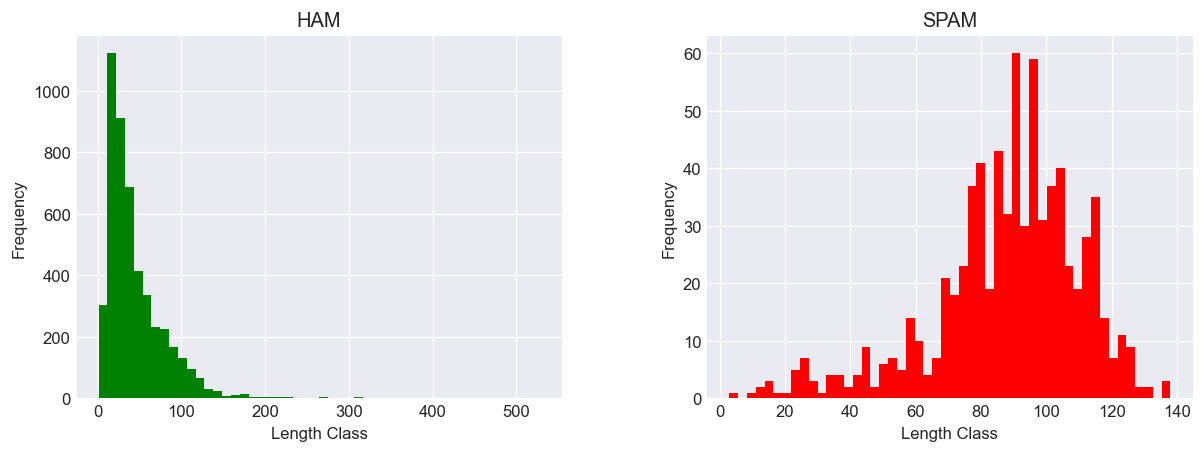

In [19]:
fig,ax = plt.subplots(1,2,figsize=(12,4),dpi = 120)

data[data['v1']=='ham'].hist(column='length', bins=50,ax=ax[0],color = 'green')
ax[0].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'HAM')
data[data['v1']=='spam'].hist(column='length', bins=50,ax=ax[1],color = 'red')
ax[1].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'SPAM');

    Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

In [20]:
np.set_printoptions(threshold=sys.maxsize)

In [21]:
x = np.array(data['cleaned-messages'])
y = np.array(data['v1'])
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.33)

## What is TF-IDF?

    TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

In [22]:
tfidfvectorizer = TfidfVectorizer(analyzer= 'word', stop_words='english')
tfidf_wm = tfidfvectorizer.fit_transform(X_train)
tfidf_tokens = tfidfvectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)


TD-IDF Vectorizer

       aa  aaniye  aaooooright  aathi  abdomen  abeg  abel  abi  ability  \
0     0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   
1     0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   
2     0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   
3     0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   
4     0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   
...   ...     ...          ...    ...      ...   ...   ...  ...      ...   
3722  0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   
3723  0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   
3724  0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   
3725  0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   
3726  0.0     0.0          0.0    0.0      0.0   0.0   0.0  0.0      0.0   

      abiola  ...  åôrents   ì_   ìï   ó_   û_  û_thanks  ûªve  ûïh

## Tokenizing The cleaned data
    tokenization is the process of splitting text into smaller chunks,
    called tokens. Each token is an input to the machine learning algorithm as a feature.

    from keras.preprocessing.text import Tokenizer:
    it is a utility function that tokenizes a text into tokens while keeping only the words that
    occur the most in the text corpus. When we tokenize the text, we end up with a massive dictionary of words,
    and they won't all be essential. we can set 'mac_features' to select the top frequent words that we want to
    consider.

In [23]:
max_feature = 50000 #number of unique words to consider
tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(X_train)
X_train_features = np.array(tokenizer.texts_to_sequences(X_train))
X_test_features = np.array(tokenizer.texts_to_sequences(X_test))

In [24]:
X_train_features

array([list([101, 13, 3073, 137, 317, 109, 3074, 527, 1990, 1200, 1523, 1991, 101, 13, 317]),
       list([14, 246, 82, 109, 48, 132, 118, 3, 31]),
       list([3075, 49, 370, 66, 289, 3076, 82, 1992]),
       list([25, 1524, 1525, 3, 392, 36, 205, 3077, 26, 3078, 3079, 26, 1993, 26, 1994, 3080, 3081, 1526]),
       list([703, 270, 247, 638, 3082, 198, 704, 259, 104, 1003, 3083, 639, 198, 133]),
       list([67, 3084, 346, 3085, 1201, 11, 19, 3086, 230, 29, 1995, 1996]),
       list([1997, 318, 1998, 870, 56, 3087, 1527, 3088, 3089, 3090, 1004]),
       list([60, 55, 528, 347, 3091, 1999, 446, 1528, 1005, 290, 3092, 3093, 3094, 3095, 121, 111]),
       list([105, 114, 45, 73, 50, 23, 63]), list([2000, 3096]),
       list([37, 319, 87, 248, 2001, 320, 1006, 260, 3097, 70, 1202, 48, 6, 48, 3098, 39, 1529, 447]),
       list([142, 319, 8, 39, 477, 3, 2002, 871, 2003, 1203, 346, 1007, 83, 80, 1530]),
       list([142, 199, 1008, 9, 10, 3099]),
       list([1009, 3100, 3101, 1010, 640, 149,

In [25]:
X_train

array(['Let know changes next hrs even appendix age range However impossible chill let know hrs',
       'll probably tomorrow even later tonight something s going',
       'Perhaps much easy give account identification tomorrow UNI',
       'want cock hubby s away need real mansatisfy Txt WIFEstrings action Txt STOPend txt rec åea OTBoxLA WS',
       'Hmm Dunno leh mayb baggoigng dat small jus anything except perfume smth dat keep',
       'Hey cutie goes WALES kinda ok like hills shit still avent killed',
       'Aww must nearly dead Well Jez isComing toDo workAnd whillTake forever',
       'msg mobile content order resent previous attempt failed due network error Queries customersqueries netvision uk com',
       'cant pick phone right Pls send message', 'donno scorable',
       'hi baby im sat bloody bus mo wont homewan na somethin later call later ortxt back jess xx',
       'Hello baby get back mom s setting computer Filling belly goes loverboy miss already sighs',
       'Hello 

## text sequencing
    Making the tokens for all emails an equal size is called padding.

    We send input in batches of data points.
    Information might be lost when inputs are of different sizes.
    So, we make them the same size using padding, and that eases batch updates

In [26]:
sum(data['length'])

282309

In [27]:
len(X_train_features)

3727

In [28]:
X_train_features = pad_sequences(X_train_features,maxlen = 2000)
X_test_features = pad_sequences(X_test_features,maxlen = 2000)

## labeling the encoding target variable
    The model will expect the target as a number and not a string. we can use label encoder
    from sklearn to convert our target variable as below:

In [29]:
le = LabelEncoder()
train_y = le.fit_transform(y_train)
test_y = le.fit_transform(y_test)

## Implementation 
# Embedding 
    Text data can be easily interpreted by humans. but for machines,
    reading and analyzing is a very complex task.
    TO accomplish this task, we need to convert our text into a machine-understandable format

    Embedding is the process of converting formatted text data into numerical values/vectors wich
    a machine can iterpret.

![alt text](https://www.tensorflow.org/text/guide/images/one-hot.png)

In [30]:
import tensorflow as tf 
from keras.layers import Dense,Input,LSTM,Embedding,Dropout,Activation,Conv1D
from keras.layers import Bidirectional,GlobalMaxPool1D
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from keras.models import Model
from keras  import initializers,regularizers,constraints,optimizers,layers


In [31]:
# size of the output vector from each layer
embedding_vector_length = 32
#creating a sequential model
model = tf.keras.Sequential()
#creating an embedding layer to vectorize
model.add(Embedding(max_feature,embedding_vector_length,input_length=2000))
#Adding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
#Relu allows converging quickly and allows backpropagation
model.add(Dense(16,activation='relu'))
#Deep learning models can be overfit easily, to avoid this, we add randomization using drop out 
model.add(Dropout(0.1))
#Adding segmoid activation function to normalize the output 
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 32)          1600000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
______________________________________________

In [ ]:
history = model.fit(X_train_features,train_y,batch_size=512,epochs=1,validation_data=(X_test_features,test_y))
y_predict = [1 if o>0.5 else 0 for o in model.predict(X_test_features)]

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

cf_matrix =confusion_matrix(test_y,y_predict)

tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()


print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');



# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);